# Final Project - Piano Roll Extraction
- Course: AAI-511-Neural Networks
- Institution: University of San Diego
- Professor: Kahila Mokhtari Jadid
- Group 4 Members: 
    * Lucas Young
    * Titouan Margret
    * Juan Pablo Triana Martinez

This notebook has the intention to go through the `final_proj_data` folder inside `data` folder, and do the following:
1. Repeat all the steps done in `eda_midi.ipynb`, with a little twist this time.
2. We would readapt one of the classes to also give us the label for each song!
3. Additionally, we are gonna take a look into `pad_sequence` function from `torch.rnn` to use it for CNN-LSTM approaches.

In [2]:
#Import necessary modules
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from pathlib import Path
print("CWD →", Path.cwd())


CWD → c:\Users\ajedr\OneDrive\Documentos\Masters_Post_Cert_AI_Stanford_USD_2023_2026\Masters_AI_Workspace\src\MSAAI-511-group-4\notebooks


In [4]:
# Data path file
curr_path = Path.cwd()
data_path = curr_path.parent / "data" / "final_proj_data"

if data_path.exists():
    print("Valid path to use to retreive midi files information")
else:
    print("Run appropiate code to retrieve the dataset")

Valid path to use to retreive midi files information


In [5]:
from mido import MidiFile
from tqdm import tqdm
from typing import List, Tuple
from pathlib import Path

def is_valid_midi(path: Path, min_size=1024, min_messages=10) -> bool:
    """Reject tiny or corrupt MIDI files."""
    if path.stat().st_size < min_size:        # < 1 KB → skip
        return False
    try:
        mid = MidiFile(path)
        return len(mid.tracks[0]) >= min_messages
    except Exception:
        return False

class MidiPreprocesser:
    '''
    Class that would process all files found
    inside the final_proj_data folder and retrieve
    all the midi info for each of the files

    Args:
        data_path : Path from pathlib where data folder is located.

    Returns:
        midi_object: will see :)

    Example:
        midipreprocesser = MidiPreprocesser(data_path = set_path)
        midiobj, labels_composer = midipreprocesser.get_midi_info()
    '''

    def __init__(self, data_path:Path):
        self.data_path = data_path
    
    def _convert_composers_class_idx(self, labels: List[str]) -> List[int]:
        class_indices = []
        for composer in labels:
            if composer == "Bach":
                class_indices.append(1)
            elif composer == "Beethoven":
                class_indices.append(2)
            elif composer == "Chopin":
                class_indices.append(3)
            elif composer == "Mozart":
                class_indices.append(4)
            else:
                class_indices.append(0)
        return class_indices

    def get_midi_info(self) -> Tuple[List[Tuple[str, MidiFile]], List[int]]:
        midis = []
        labels_composer = []
        for root, dirs, files in tqdm(self.data_path.walk(), desc="Reading composers.."):
            count = 0
            for file in tqdm(files, desc=f"Reading_{root.stem} files...", total=len(files)):
                if file.endswith(".mid"):
                    fpath = Path(root) / file         # ← create Path object here
                
                if file.endswith(".mid"):
                    try:
                        midis.append((root.stem + "_" + str(count), MidiFile(Path(root) / file)))
                        labels_composer.append(root.name)
                        count += 1
                    except:
                        print(f"{file} cannot be read, is skipped")
                        continue
        labels_composer = self._convert_composers_class_idx(labels_composer)
        return midis, labels_composer

In [6]:
midipreprocesser = MidiPreprocesser(data_path = data_path)
midiobj, labels_composer = midipreprocesser.get_midi_info()

Reading_final_proj_data files...: 0it [00:00, ?it/s]
Reading_Bach files...: 100%|██████████| 122/122 [00:05<00:00, 24.21it/s]
Reading composers..: 2it [00:05,  2.54s/it]

Anhang 14-3.mid cannot be read, is skipped


Reading_Mozart files...: 100%|██████████| 90/90 [00:04<00:00, 18.64it/s]
Reading composers..: 5it [00:24,  4.98s/it]


### Labels distribution.
Now that we have the array of labels for each composer, the next step is to do the following:
1. Plot the histogram of the labels to see their distribution, in order to handle unbalanced data

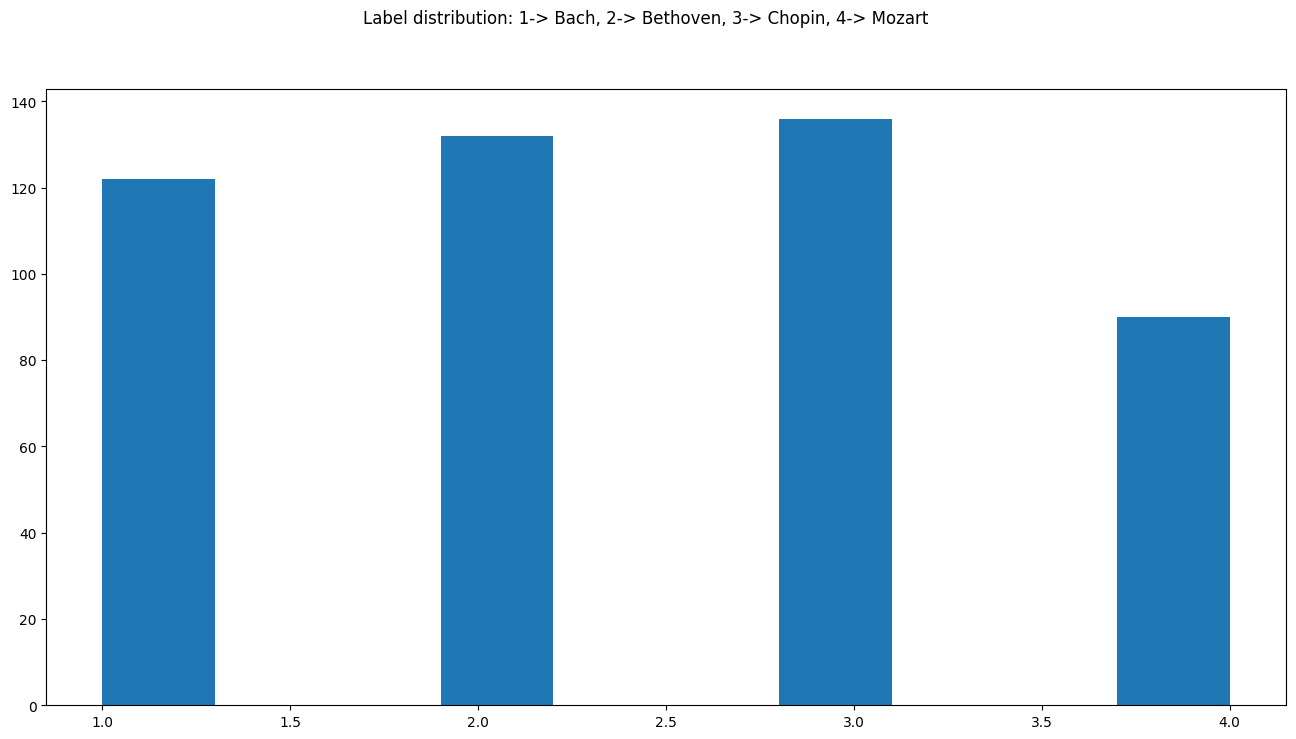

In [7]:
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Label distribution: 1-> Bach, 2-> Bethoven, 3-> Chopin, 4-> Mozart")
ax1 = fig.add_subplot(1, 1, 1)
ax1.hist(labels_composer)
plt.show()

### UNBALANCED DATASET
Well! This is surprising, we have now an unbalanced label towards `Chopin` music, this is gonna be key when we are dealing with data augmentation techniques,
specially, these are the following issues:
- After converting the files to `np.ndarrays` and store them in a `List`, we are gonna use `pad_sequences` to pad them properly
- After this, we would create a **DataAugmentation** pipeline to set a certain number of images, we would like to have:
    - 300 Images per composer, meaning we would need to oversample `Bach`,  `Bethoven`, and `Mozart`, and undersample `Chopin`
- Finally, create a customized `Dataset` from `torch.utils.data`. 

In [8]:
from collections import Counter
cnt = Counter(labels_composer)          # labels_composer from get_midi_info
for lab,name in {1:'Bach',2:'Beethoven',3:'Chopin',4:'Mozart'}.items():
    print(f"{name:9s} ({lab}): {cnt[lab]}")


Bach      (1): 122
Beethoven (2): 132
Chopin    (3): 136
Mozart    (4): 90


In [9]:
from mido import MidiFile
from typing import Union, Tuple
import numpy as np

class MidiToNumpy:
    '''
    Class that would process one Midifile
    object, and do the following:
        - Set the midi ticks per beat
        - Set the fs to discretize Midi information -> Discrete symbolic numpy array
        - Iterate across all tracks and find events of the following:
            * set_tempo
            * note_on
            * note_off
        - create a numpy array of zeroes of size (128, T) 

        Args:
            file: Midifile containing all tracks to use.
            tempo: Integer representing default tempo time for a midi file in microseconds/beat.
            values can be 500,000 or 1000,000
            fs: Integer representing discretize frequency sample time for evets, default = 10
        
        Returns:
            np_piano: np.ndarray of size (128, T) representation
            of the midi file

        Example:
            midi_np_processor = MidiToNumpy(file = midi_file,
                                default_tempo = 500000, fs = 10)
            np_midi = midi_np_processor.get_np_array()
    '''

    def __init__(self, file:MidiFile, default_tempo:int = 500000, fs:int = 10) -> None:
        self.file = file
        self.ticks_per_beat = file.ticks_per_beat
        self.tempo = default_tempo
        self.fs = fs

    def _calculate_seconds(self, ticks:int) -> Union[float, int]:
        return (ticks / self.ticks_per_beat) * (self.tempo / 1_000_000)

    def _get_np_array_info(self) -> Tuple[float, float, int, int]:
        # List to hold note start and end info
        notes = []

        for track in self.file.tracks:
            time_ticks = 0
            ongoing_notes = {}
            for msg in track:
                time_ticks += msg.time
                if msg.type == 'set_tempo':
                    self.tempo = msg.tempo
                elif msg.type == 'note_on' and msg.velocity > 0:
                    # Start note
                    ongoing_notes[msg.note] = (time_ticks, msg.note, msg.velocity)
                elif (msg.type == 'note_off') or (msg.type == 'note_on' and msg.velocity == 0):
                    # End note
                    if msg.note in ongoing_notes:
                        start_time_ticks, note, note_velocity = ongoing_notes.pop(msg.note)
                        
                        #Convert tick times to seconds
                        start_time = self._calculate_seconds(ticks=start_time_ticks)
                        time = self._calculate_seconds(ticks=time_ticks)
                        notes.append((start_time, time, note, note_velocity))
        return notes

    def get_np_array(self) -> Tuple[np.ndarray[int, float], str]:
        notes_info = self._get_np_array_info()

        #Let's get end time to create he np.ndarray
        _ , final_time , _ , _ = notes_info[-1]
        np_array = np.zeros(shape = (128, int(np.floor(final_time)*self.fs)), dtype=np.float32)

        for start_time, time, note, note_velocity in tqdm(notes_info, desc=f"Creating Piano roll: {self.file.filename.stem}", total=len(notes_info)):
            start_time_clipped = int(np.round(start_time*self.fs))
            time_clipped = int(np.round(time*self.fs))
            np_array[note, start_time_clipped:time_clipped] = note_velocity

        return np_array, self.file.filename.stem


In [10]:
def obtain_piano_rolls(midiobject: List[Tuple[str, MidiFile]]) -> Tuple [List[np.ndarray], List[str], List[str]]:
    '''
    Args:
        midiobject: list containing tuples of song names and related MidiFile
    
    Returns:
        list_np_arrays: list of np_arrays for each of the piano rolls.
        list_composer_names: list containing composer names.
        list_file_names: List containing song names.
    
    Example:
        list_np_arrays, list_composer_names = obtain_piano_rolls(midiobject = midiobj)
    '''

    list_np_arrays = []
    list_comp_names = []
    list_song_names = []
    for name , midifile in midiobject:
        # With customized class
        midi_np_processor = MidiToNumpy(file = midifile,
                            default_tempo = 500000, fs = 10)
        np_array, file_name = midi_np_processor.get_np_array()
        list_song_names.append(file_name)
        list_np_arrays.append(np_array)
        list_comp_names.append(name)

    return list_np_arrays, list_comp_names, list_song_names

In [11]:
list_np_arrays, list_composer_names, list_song_names = obtain_piano_rolls(midiobject = midiobj)

Creating Piano roll: Bwv0537 Fantasia and Fugue: 100%|██████████| 3018/3018 [00:00<00:00, 188016.66it/s]
Creating Piano roll: Bwv0538 Toccata and Fugue ''Dorian'': 100%|██████████| 5846/5846 [00:00<00:00, 190832.69it/s]
Creating Piano roll: Bwv0551 Prelude and Fugue: 100%|██████████| 1968/1968 [00:00<00:00, 206618.03it/s]
Creating Piano roll: Bwv0552 Prelude and Fugue ''St. Anne'': 100%|██████████| 6439/6439 [00:00<00:00, 200397.15it/s]
Creating Piano roll: Bwv0554 Short Prelude and Fugue n2 (Spurious): 100%|██████████| 1256/1256 [00:00<00:00, 165656.61it/s]
Creating Piano roll: Bwv0555 Short Prelude and Fugue n3 (Spurious): 100%|██████████| 968/968 [00:00<00:00, 147521.48it/s]
Creating Piano roll: Bwv0556 Short Prelude and Fugue n4 (Spurious): 100%|██████████| 1256/1256 [00:00<00:00, 227807.39it/s]
Creating Piano roll: Bwv0557 Short Prelude and Fugue n5 (Spurious): 100%|██████████| 937/937 [00:00<00:00, 146365.60it/s]
Creating Piano roll: Bwv0558 Short Prelude and Fugue n6 (Spurious):

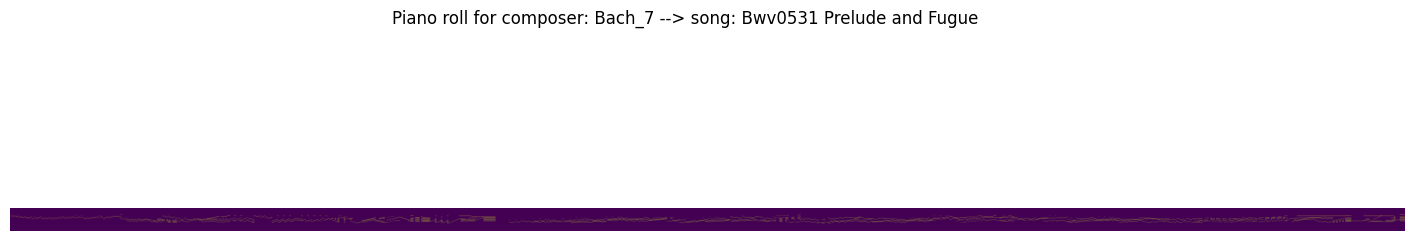

Piano roll for composer: Bach_0 --> song: AveMaria: shape is (128, 790)
Piano roll for composer: Bach_1 --> song: Bwv0525 Sonate en trio n1: shape is (128, 11560)
Piano roll for composer: Bach_2 --> song: Bwv0526 Sonate en trio n2: shape is (128, 10620)
Piano roll for composer: Bach_3 --> song: Bwv0527 Sonate en trio n3: shape is (128, 15750)
Piano roll for composer: Bach_4 --> song: Bwv0528 Sonate en trio n4: shape is (128, 10650)
Piano roll for composer: Bach_5 --> song: Bwv0529 Sonate en trio n5: shape is (128, 12780)
Piano roll for composer: Bach_6 --> song: Bwv0530 Sonate en trio n6: shape is (128, 13710)
Piano roll for composer: Bach_7 --> song: Bwv0531 Prelude and Fugue: shape is (128, 7880)
Piano roll for composer: Bach_8 --> song: Bwv0532 Toccata and Fugue: shape is (128, 4470)
Piano roll for composer: Bach_9 --> song: Bwv0533 Prelude and Fugue: shape is (128, 3310)
['Bach_0' 'Bach_1' 'Bach_10' 'Bach_100' 'Bach_101' 'Bach_102' 'Bach_103'
 'Bach_104' 'Bach_105' 'Bach_106' 'Bach

In [12]:
index = 7
fig = plt.figure(figsize=(18, 4))
fig.suptitle(f"Piano roll for composer: {list_composer_names[index]} --> song: {list_song_names[index]}")
fig.subplots_adjust(top = 0.8)
ax1 = fig.add_subplot(1, 1, 1)
ax1.imshow(list_np_arrays[index], label = list_composer_names[index])
ax1.axis("off")
plt.show()

for i, np_array in enumerate(list_np_arrays[0:10]):
    print(f"Piano roll for composer: {list_composer_names[i]} --> song: {list_song_names[i]}: shape is {np_array.shape}")
print(np.unique(list_composer_names))


### NICE!
Lets create a function that pads them properly!
- Now, this is gonna be difficult, first we need to take a look into the list of np_arrays and see the distribution of the time lengths.
- Looking at the distribution, select a default time . Remember, we used `fs = 10`, which means we can see the time distributions with `np_array.shape[1]/fs`.
- Once we have that, we can create a class that would pad ALL of the np_arrays properly by using `torch.tensor.repeat` along axis = 1 -> `shape = (128, T)`
- **MAINTAIN NP ARRAY ORDER**, So when we start oversampling and undersampling, we are able to have proper labels vs piano roll images.

2515.0
251.5


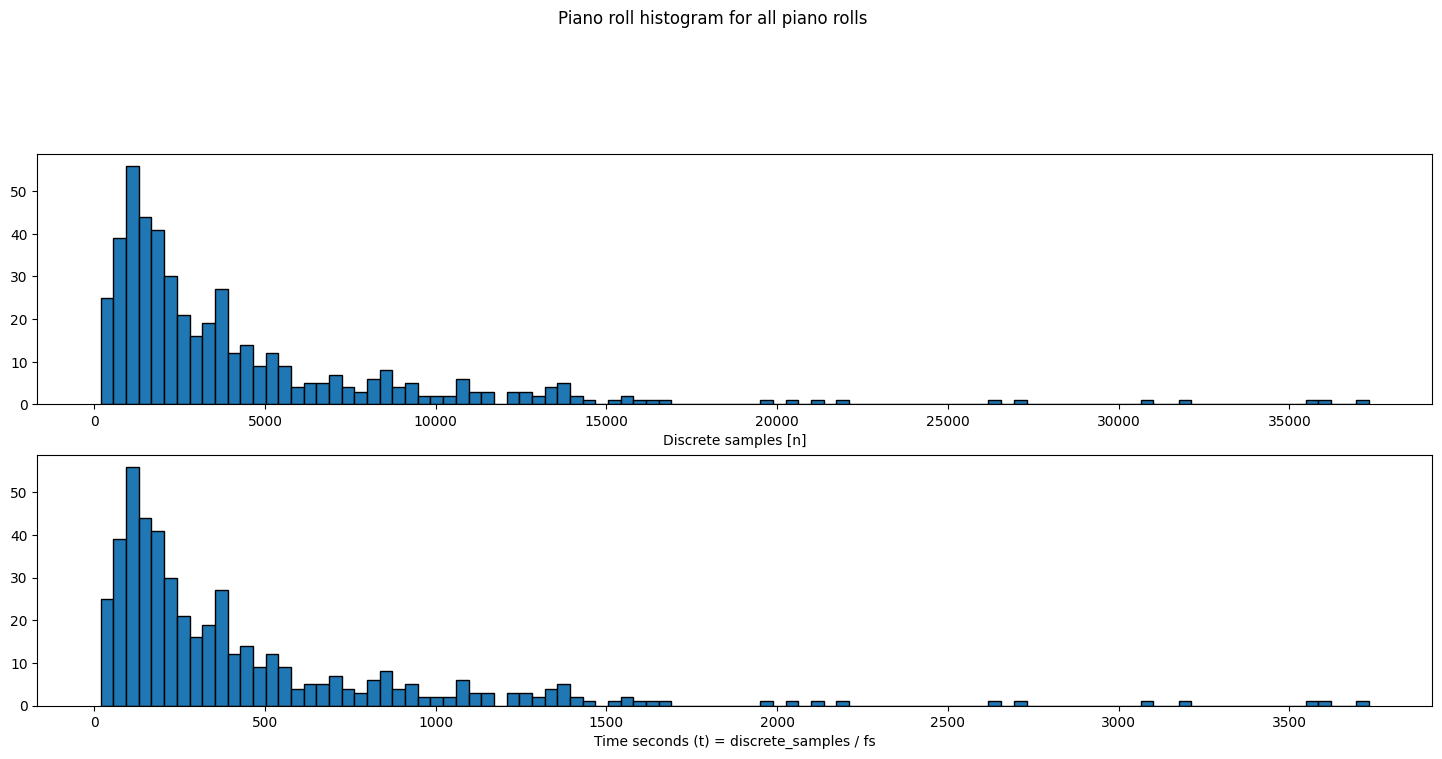

In [13]:
discrete_lengths = []
time_lenghts = []
fs = 10
for i in range(len(list_np_arrays)):
    len_array = list_np_arrays[i].shape[1]
    discrete_lengths.append(len_array)
    time_lenghts.append(len_array/fs)

fig = plt.figure(figsize=(18, 8))
fig.suptitle(f"Piano roll histogram for all piano rolls")
fig.subplots_adjust(top = 0.8)
ax1 = fig.add_subplot(2, 1, 1)
ax1.hist(discrete_lengths, edgecolor = "black", bins=100)
ax1.set_xlabel("Discrete samples [n]")
print(np.median(discrete_lengths))

ax2 = fig.add_subplot(2, 1, 2)
ax2.hist(time_lenghts, edgecolor = "black",  bins=100)
ax2.set_xlabel("Time seconds (t) = discrete_samples / fs")
print(np.median(time_lenghts))

The observations of the lengths of different time songs show that its skewed to the left, meaning that we would like to select a right size like this:
- If the song has more than the `np.median` of lengths, then select like this `ndarray[:, :np.median(lengths))]`.
- If song has less than the median of lengths do the following:
    - set `max_len_array = np.median(lengths)`
    - calculate `repeats = (max_len_array // ndarray.shape[1]) + 1`
    - tiled is `tensor.repeat(1, repeats)`
    - check if `tiled.shape[1] >= max_len_array`, if it is, then `tiled[:, :max_len_array]`, else: repeat again with tile until you select `tiled[:, :max_len_array]`

3733.0
torch.Size([128, 790])
torch.Size([128, 37330])


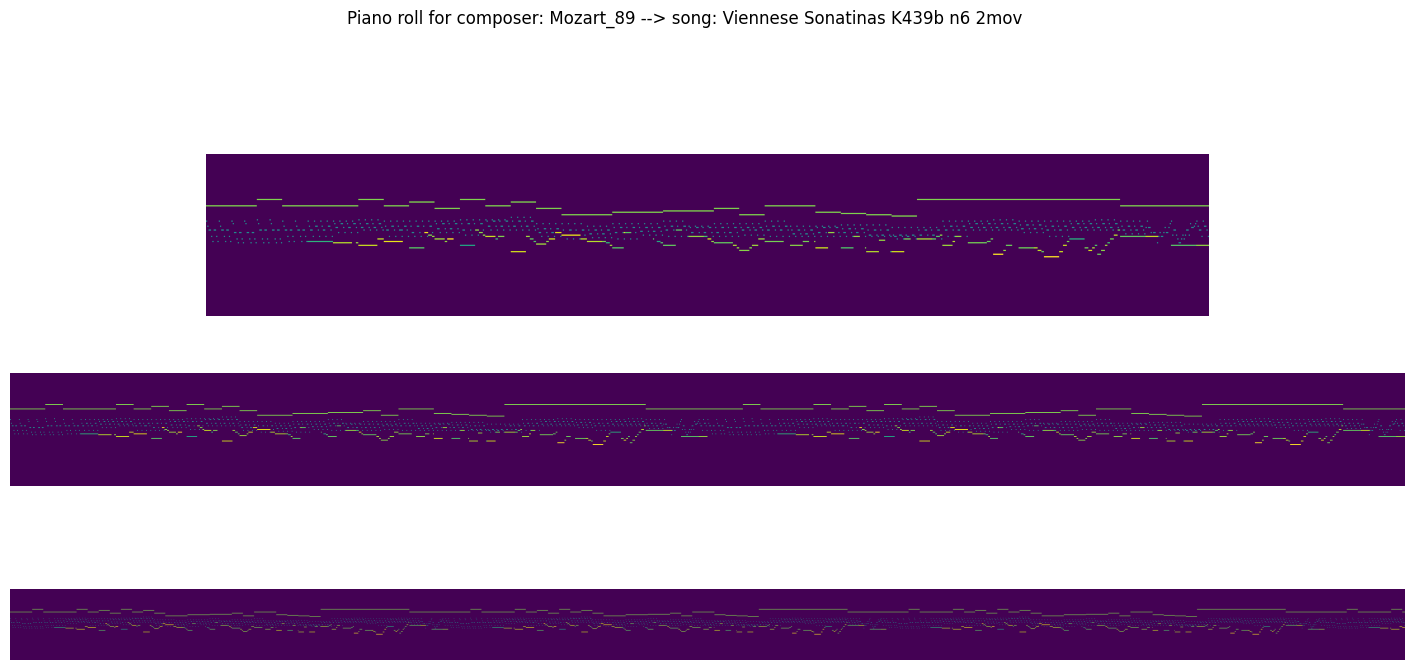

In [14]:
import torch
import torch.nn.functional as F

max_len_array = 0
for i in range(len(list_np_arrays)):
    len_array = list_np_arrays[i].shape[1]
    if len_array > max_len_array:
        max_len_array = len_array
print(max_len_array/10)

index = 0
tensor = torch.tensor(list_np_arrays[index])  # Shape: [128, T]
repeats = (max_len_array // tensor.shape[1]) + 1
tiled = tensor.repeat(1, repeats)  # Repeat along time axis
padded_tensor = tiled[:, :max_len_array]  # Trim to target size

print(tensor.shape)
print(padded_tensor.shape)

index = i
fig = plt.figure(figsize=(18, 8))
fig.suptitle(f"Piano roll for composer: {list_composer_names[index]} --> song: {list_song_names[index]}")
fig.subplots_adjust(top = 0.8)
ax1 = fig.add_subplot(3, 1, 1)
ax1.imshow(tensor, label = list_composer_names[index])
ax1.axis("off")

ax2 = fig.add_subplot(3, 1, 2)
ax2.imshow(padded_tensor[:, 0:2*tensor.shape[1]], label = list_composer_names[index])
ax2.axis("off")

ax3 = fig.add_subplot(3, 1, 3)
ax3.imshow(padded_tensor[:, 0:int(np.median(discrete_lengths))], label = list_composer_names[index])
ax3.axis("off")

plt.show()



In [15]:
class PianoRollsDiscreteEqualizer:
    '''
    Class that woild take a list of np.ndarrays of size
    (128, T). Where T is a varying number of discrete samples
    per piano roll.

    Args:
        - piano_rolls: List of np.ndarrays of size (128, T), with varying Ts
        - threshold: Integer of samples to equalize across all piano arrays.
    
    Returns:
        - equalized_piano_rolls: np.ndarray of shape (N, 128, Teq)
    
    Example:
        equalizer = PianoRollsDiscreteEqualizer(piano_rolls = previous_pianos)
        eq_piano_rolls = equalizer.get_equalized()
    '''

    def __init__(self,
        piano_rolls: List[np.ndarray],
        threshold: int = 2515) -> None:

        self.piano_rolls = piano_rolls
        self.piano_diff_lengths = []
        self.threshold = threshold
    
    def get_equalized(self) -> np.ndarray[int]:
        equalized_np_arrays = []
        for nparray in tqdm(self.piano_rolls, desc="Equalizing piano rolls...", total=len(self.piano_rolls)):
            if len(nparray) >= self.threshold:
                equalized_np_arrays.append(nparray[:, :self.threshold])
            else:
                tiled = nparray
                while tiled.shape[1] < self.threshold:
                    repeats = int((self.threshold // tiled.shape[1]) + 1)
                    tiled = np.tile(tiled, repeats)  # Repeat along time axis
                equalized_np_arrays.append(tiled[:, :self.threshold])

        return np.array(equalized_np_arrays, dtype=np.int64)
        

In [16]:
def calculate_median_various_lengths(piano_uneq_arrays:List[np.ndarray]) -> int:
    piano_diff_lengths = []
    for nparray in piano_uneq_arrays:
        piano_diff_lengths.append(nparray.shape[1])
    return  int(np.median(piano_diff_lengths))

equalizer = PianoRollsDiscreteEqualizer(piano_rolls = list_np_arrays, threshold=2515)
eq_piano_rolls = equalizer.get_equalized()
print(eq_piano_rolls.shape)

Equalizing piano rolls...: 100%|██████████| 480/480 [00:00<00:00, 2693.77it/s]


(480, 128, 2515)


### Lil reminder
* We are setting up until the `np.median()` of the songs. However, upon close data inspection of the discrete sample distributions; it's obvious we are dealing with a bimodal distribution before 5000 samples.
* IN the future, instead of using the `np.median()` setting it at a higher number of samples should be explored as a hyperparameter.

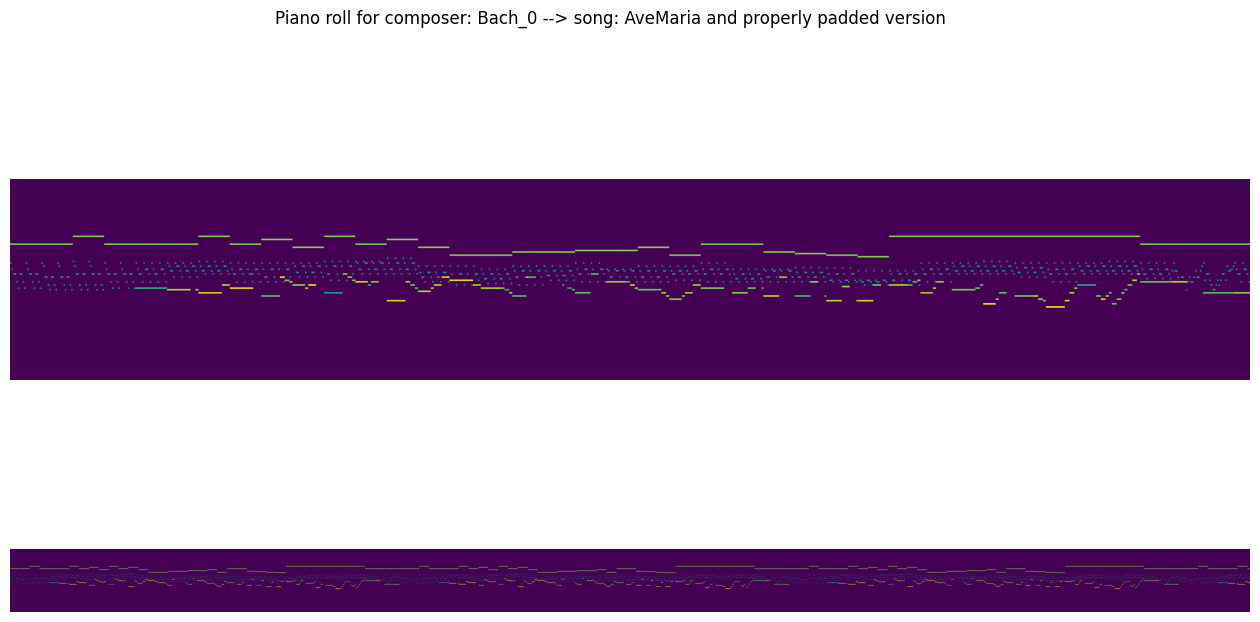

In [17]:
index = 0
fig = plt.figure(figsize=(16, 8))
fig.suptitle(f"Piano roll for composer: {list_composer_names[index]} --> song: {list_song_names[index]} and properly padded version")
fig.subplots_adjust(top = 0.8)
ax1 = fig.add_subplot(2, 1, 1)
ax1.imshow(list_np_arrays[index], label = list_composer_names[index])
ax1.axis("off")

ax2 = fig.add_subplot(2, 1, 2)
ax2.imshow(eq_piano_rolls[index], label = list_composer_names[index])
ax2.axis("off")

plt.show()
